In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [260]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image(pred_batch, truth_batch, grid_len, debug=False):
        '''euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
            pred, truth = pred[0], truth[0]  # there is only one channel
            indx = np.argmax(pred)
            pred_x = indx // grid_len
            pred_y = indx %  grid_len
            indx = np.argmax(truth)
            true_x = indx // grid_len
            true_y = indx %  grid_len
            err = Utility.distance((pred_x, pred_y), (true_x, true_y))
            if debug:
                print((pred_x, pred_y), (true_x, true_y), err)
            error.append(err)
        return error

    @staticmethod
    def localization_error_image_continuous(pred_batch, truth_batch, grid_len, debug=False):
        '''Continuous
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch  -- size=(N, 1, 100, 100)
            truth_batch -- size=(N, 2)
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
            pred = pred[0]  # there is only one channel
            indx = np.argmax(pred)
            pred_x = indx // grid_len
            pred_y = indx %  grid_len
            neighbor = []
            sum_weight = 0
            for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                nxt = (pred_x + d[0], pred_y + d[1])
                if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                    neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                    sum_weight += pred[nxt[0]][nxt[1]]
            pred_x, pred_y = 0, 0
            for n in neighbor:
                loc = n[0]
                w   = n[1]
                pred_x += loc[0]/sum_weight*w
                pred_y += loc[1]/sum_weight*w
            err = Utility.distance((pred_x, pred_y), truth)
            if debug:
                print((pred_x, pred_y), (truth[0], truth[1]), err)
            error.append(err)
        return error

# 2 Output is image, model as image segmentation problem

## Output representation is a grid (image)
## Use weighting to get a continuous output prediction

## Data

In [253]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        sample = {'matrix':matrix, 'target':target_img, 'target_float':target_float}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_translation_target(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixel with the TX is labeled 1, everywhere else is labeled 0
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        x, y = location[0], location[1]
        target_float = (x, y)
        x, y = int(x), int(y)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        neighbor = []
        sum_weight = 0
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                nxt = (x + i, y + j)
                if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                    weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                    sum_weight += weight
                    neighbor.append((nxt, weight))
        for n, w in neighbor:
            grid[n[0]][n[1]] = w / sum_weight * len(neighbor)
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), np.array(target_float)



tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
root_dir = './data/matrix-train20'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[0]['matrix'].shape)
print(sensor_input_dataset[0]['target'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test20'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[0]['matrix'].shape)
print(sensor_input_test_dataset[0]['target'])
print(sensor_input_test_dataset[0]['target_float'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[[[2.2074277  0.53392583 0.         ... 0.         0.         0.        ]
  [0.8044668  0.45417964 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
100000
torch.Size([1, 100, 100])
[[[1.4273249  1.3868178  0.         ... 0.         0.         0.        ]
  [0.59444475 0.59141254 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
[0.17146571 0.9896948 ]
20000


## Model

In [254]:
# model

class Net2(nn.Module):
    '''The output dimension of the full connnection layer is 100 x 100 = 10000
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv2d(8, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, 5, padding=2)
        self.groupnorm1 = nn.GroupNorm(1, 8)
        self.groupnorm2 = nn.GroupNorm(1, 32)
        
    def forward(self, x):
#         x = F.relu(self.groupnorm1(self.conv1(x)))
#         x = F.relu(self.groupnorm2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

net2 = Net2()
print(net2)

Net2(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (groupnorm1): GroupNorm(1, 8, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(1, 32, eps=1e-05, affine=True)
)


## Loss is nn.MSELoss()

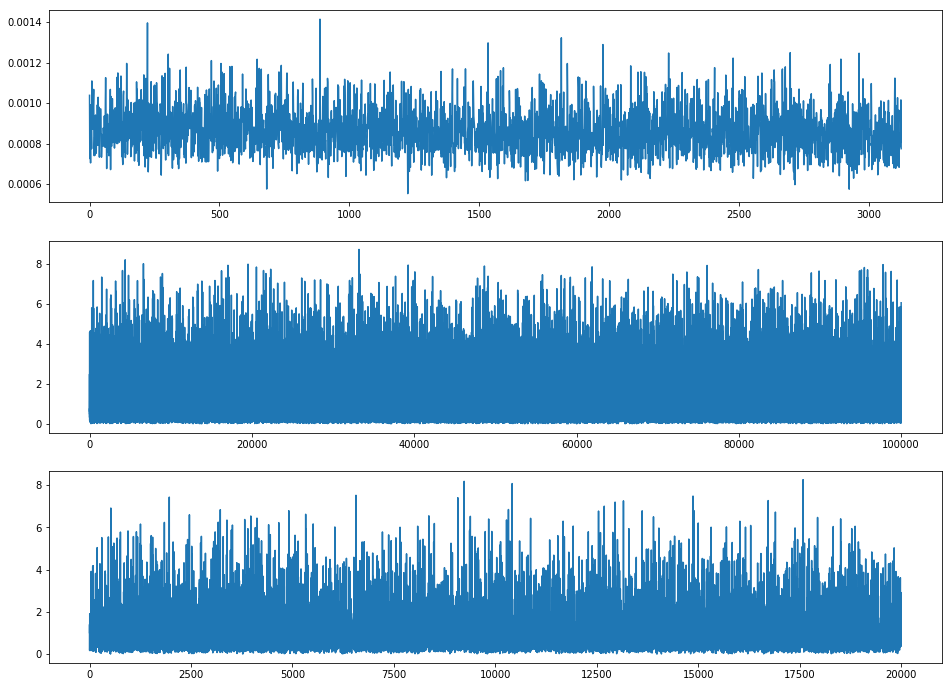

train loss mean = 0.0008627843654341996
train loss std  = 0.00011115531353579383
train mean = 1.0377845976024416
train std  = 0.9359430302610972
test mean = 1.0049826245256475
test std  = 0.9271845874683898
train loss
(0.0010026383835636079, 0.00016419908616125046)
(0.0008627843654341996, 0.00011115531353579383)
train error
(1.3372837599039455, 1.2519705603812197)
(1.0377845976024416, 0.9359430302610972)
test error
(1.0360584653344416, 0.859294727856825)
(1.0049826245256475, 0.9271845874683898)


In [256]:
# %%time
# segmentation problem

net2 = Net2()

device    = torch.device('cuda')
model     = net2.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

num_epochs = 2
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
print_every = 500

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_float = sample['target_float']
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
        train_errors.extend(Metrics.localization_error_image_continuous(pred, y_float, Default.grid_length))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')
    
    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_float = sample['target_float']
        pred = model(X)
        pred = pred.data.cpu()
        test_errors.extend(Metrics.localization_error_image_continuous(pred, y_float, Default.grid_length))
    
    clear_output(True)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
    plt.plot(train_errors)
    plt.subplot(313)
    plt.plot(test_errors)
    plt.show()
    
    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test error')
for error in test_errors_epoch:
    print(error)

In [261]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_f = sample['target_float']
    pred = model(X)
    errors = Metrics.localization_error_image_continuous(pred.data.cpu(), y_f, Default.grid_length, True)
    print(np.mean(errors), np.std(errors))
    break

X    = X.data.cpu().numpy()
pred = pred.data.cpu().numpy()
y    = y.data.cpu().numpy()

(tensor(64.5253), tensor(75.5233)) (tensor(65.2058), tensor(75.1437)) 0.7792247461578201
(tensor(50.3706), tensor(34.5346)) (tensor(45.6129), tensor(34.5939)) 4.7580981239312425
(tensor(48.5887), tensor(53.6219)) (tensor(48.4124), tensor(54.0394)) 0.453233442813121
(tensor(16.5640), tensor(41.5518)) (tensor(16.5843), tensor(42.8142)) 1.2625831501083404
(tensor(93.4677), tensor(43.4439)) (tensor(94.0909), tensor(43.7945)) 0.715070511335519
(tensor(21.5438), tensor(2.5401)) (tensor(22.4999), tensor(1.3245)) 1.5464763705708169
(tensor(31.5382), tensor(14.5389)) (tensor(31.4640), tensor(14.6267)) 0.11501942403810686
(tensor(21.6232), tensor(8.6441)) (tensor(22.1534), tensor(9.7027)) 1.1839543665069296
(tensor(55.6387), tensor(85.6264)) (tensor(56.1046), tensor(85.4935)) 0.4845169074855238
(tensor(56.6407), tensor(96.4958)) (tensor(57.1079), tensor(96.4450)) 0.4699494433858242
(tensor(65.5537), tensor(43.4650)) (tensor(65.2865), tensor(42.8417)) 0.6781783175273501
(tensor(12.5767), tensor(7

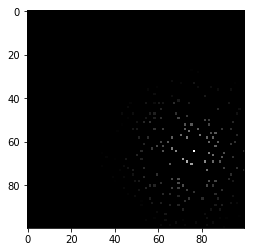

In [262]:
i = 0
plt.imshow(X[i, 0], cmap='gray')

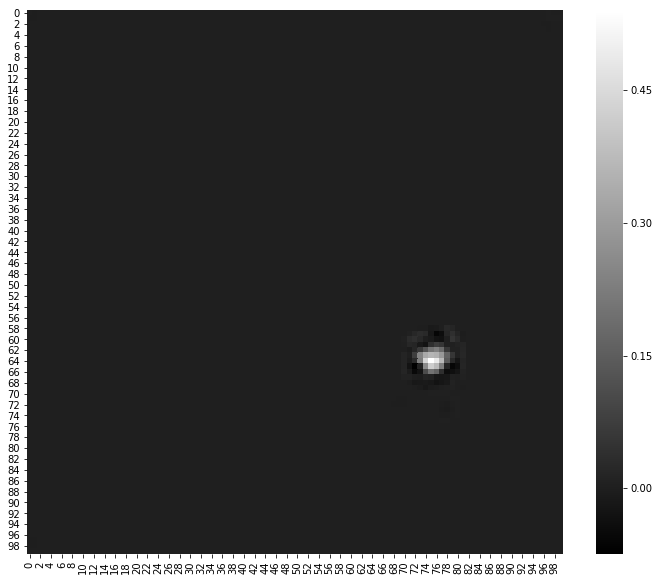

In [263]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred[i, 0], cmap='gray', annot=False)

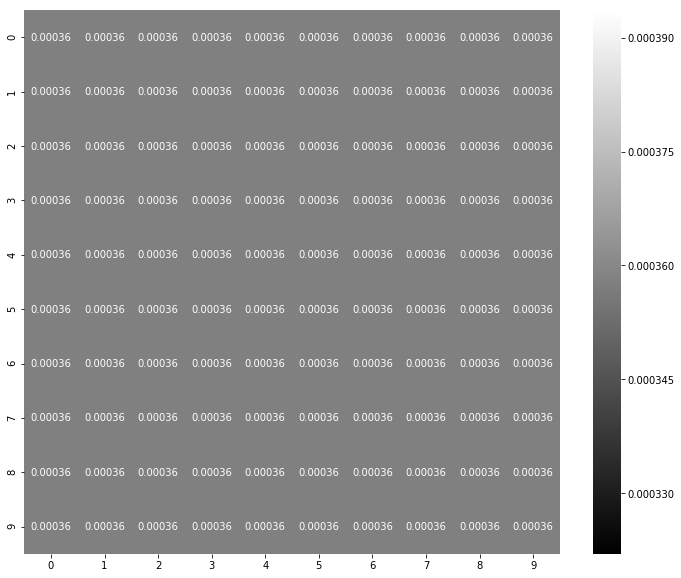

In [264]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred[i, 0][50:60, 0:10], cmap='gray', annot=True)

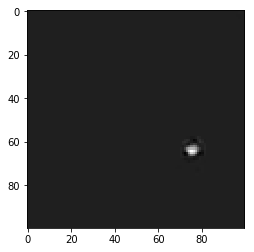

In [265]:
plt.imshow(pred[i, 0], cmap='gray')

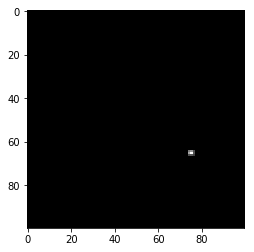

In [266]:
plt.imshow(y[i, 0], cmap='gray')

# Mics

In [81]:
a = [1, 2, 3]
b = [10, 11, 12]
c = [100, 101, 102]

for i, j, k in zip(a, b, c):
    print(i, j, k)

1 10 100
2 11 101
3 12 102


In [271]:
matrix1_name = './data/matrix-train20/000000/0.npy'
matrix2_name = './data/matrix-train31/000000/0.npy'

In [273]:
a = np.load(matrix1_name)

In [274]:
b = np.load(matrix2_name)

In [275]:
a - b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)